In [7]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import talib
import pynance as pn
from datetime import datetime, timedelta
import sys
from pathlib import Path

# Add project root to path for importing our module
sys.path.append(str(Path.cwd().parent))
from src.quantitative_analysis import QuantitativeAnalyzer

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# Configure plotting
sns.set_theme()  # Use seaborn's default theme
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# Initialize our analyzer
analyzer = QuantitativeAnalyzer()

# Load the news data to get stock symbols
print("Loading news data...")
news_df = pd.read_csv('../data/raw/raw_analyst_ratings.csv')

# Get unique stock symbols and their frequency
stock_counts = news_df['stock'].value_counts()
print("\nTop 10 most mentioned stocks:")
print(stock_counts.head(10))


Loading news data...

Top 10 most mentioned stocks:
stock
MRK     3333
MS      3238
NVDA    3146
MU      3142
QQQ     3106
NFLX    3028
M       3025
EBAY    3018
GILD    2968
VZ      2966
Name: count, dtype: int64


In [8]:
# Function to fetch stock data
def fetch_stock_data(symbol, start_date, end_date):
    """Fetch stock data using yfinance."""
    try:
        stock = yf.Ticker(symbol)
        df = stock.history(start=start_date, end=end_date)
        if len(df) > 0:
            return df
        else:
            print(f"No data found for {symbol}")
            return None
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")
        return None

# Check the date format first
print("Sample dates from the dataset:")
print(news_df['date'].head())

# Parse dates and convert to UTC
news_df['date'] = pd.to_datetime(news_df['date'], format='mixed', utc=True)

# Get the date range
start_date = news_df['date'].min().tz_convert('UTC')
end_date = news_df['date'].max().tz_convert('UTC')

print(f"\nData range: {start_date} to {end_date}")

# Convert dates to string format for yfinance (which expects YYYY-MM-DD)
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# Get top 5 most mentioned stocks
top_stocks = stock_counts.head(5).index.tolist()

# Fetch data for top stocks
stock_data = {}
for symbol in top_stocks:
    data = fetch_stock_data(symbol, start_date_str, end_date_str)
    if data is not None:
        stock_data[symbol] = data
        print(f"Loaded data for {symbol}: {len(data)} records")


Sample dates from the dataset:
0    2020-06-05 10:30:54-04:00
1    2020-06-03 10:45:20-04:00
2    2020-05-26 04:30:07-04:00
3    2020-05-22 12:45:06-04:00
4    2020-05-22 11:38:59-04:00
Name: date, dtype: object

Data range: 2009-02-14 00:00:00+00:00 to 2020-06-11 21:12:35+00:00
Loaded data for MRK: 2849 records
Loaded data for MS: 2849 records
Loaded data for NVDA: 2849 records
Loaded data for MU: 2849 records
Loaded data for QQQ: 2849 records


In [9]:
# Calculate indicators for each stock
analyzed_data = {}
for symbol, data in stock_data.items():
    # Calculate technical indicators
    df_with_indicators = analyzer.calculate_technical_indicators(data)

    # Calculate financial metrics
    metrics = analyzer.calculate_financial_metrics(data)

    # Analyze volume profile
    volume_analysis = analyzer.analyze_volume_profile(data)

    # Find support and resistance levels
    support, resistance = analyzer.identify_support_resistance(data)

    analyzed_data[symbol] = {
        'data': df_with_indicators,
        'metrics': metrics,
        'volume_analysis': volume_analysis,
        'support_levels': support,
        'resistance_levels': resistance
    }

    print(f"\nAnalysis completed for {symbol}")
    print("\nFinancial Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    print("\nVolume Analysis:")
    for metric, value in volume_analysis.items():
        if metric != 'high_volume_days':
            print(f"{metric}: {value:.4f}")
    print(f"Number of high volume days: {len(volume_analysis['high_volume_days'])}")

    print("\nSupport and Resistance Levels:")
    print(f"Found {len(support)} support levels and {len(resistance)} resistance levels")



Analysis completed for MRK

Financial Metrics:
daily_returns_mean: 0.0006
daily_returns_std: 0.0140
annualized_volatility: 0.2226
sharpe_ratio: 0.6911
max_drawdown: -0.2726

Volume Analysis:
avg_volume: 13513086.5430
volume_trend: -3304.1669
volume_price_corr: -0.3772
Number of high volume days: 109

Support and Resistance Levels:
Found 51 support levels and 48 resistance levels

Analysis completed for MS

Financial Metrics:
daily_returns_mean: 0.0007
daily_returns_std: 0.0249
annualized_volatility: 0.3960
sharpe_ratio: 0.4373
max_drawdown: -0.6460

Volume Analysis:
avg_volume: 15856646.1565
volume_trend: -5959.8338
volume_price_corr: -0.4979
Number of high volume days: 129

Support and Resistance Levels:
Found 49 support levels and 48 resistance levels

Analysis completed for NVDA

Financial Metrics:
daily_returns_mean: 0.0018
daily_returns_std: 0.0274
annualized_volatility: 0.4352
sharpe_ratio: 1.0199
max_drawdown: -0.5604

Volume Analysis:
avg_volume: 541768289.2243
volume_trend: -

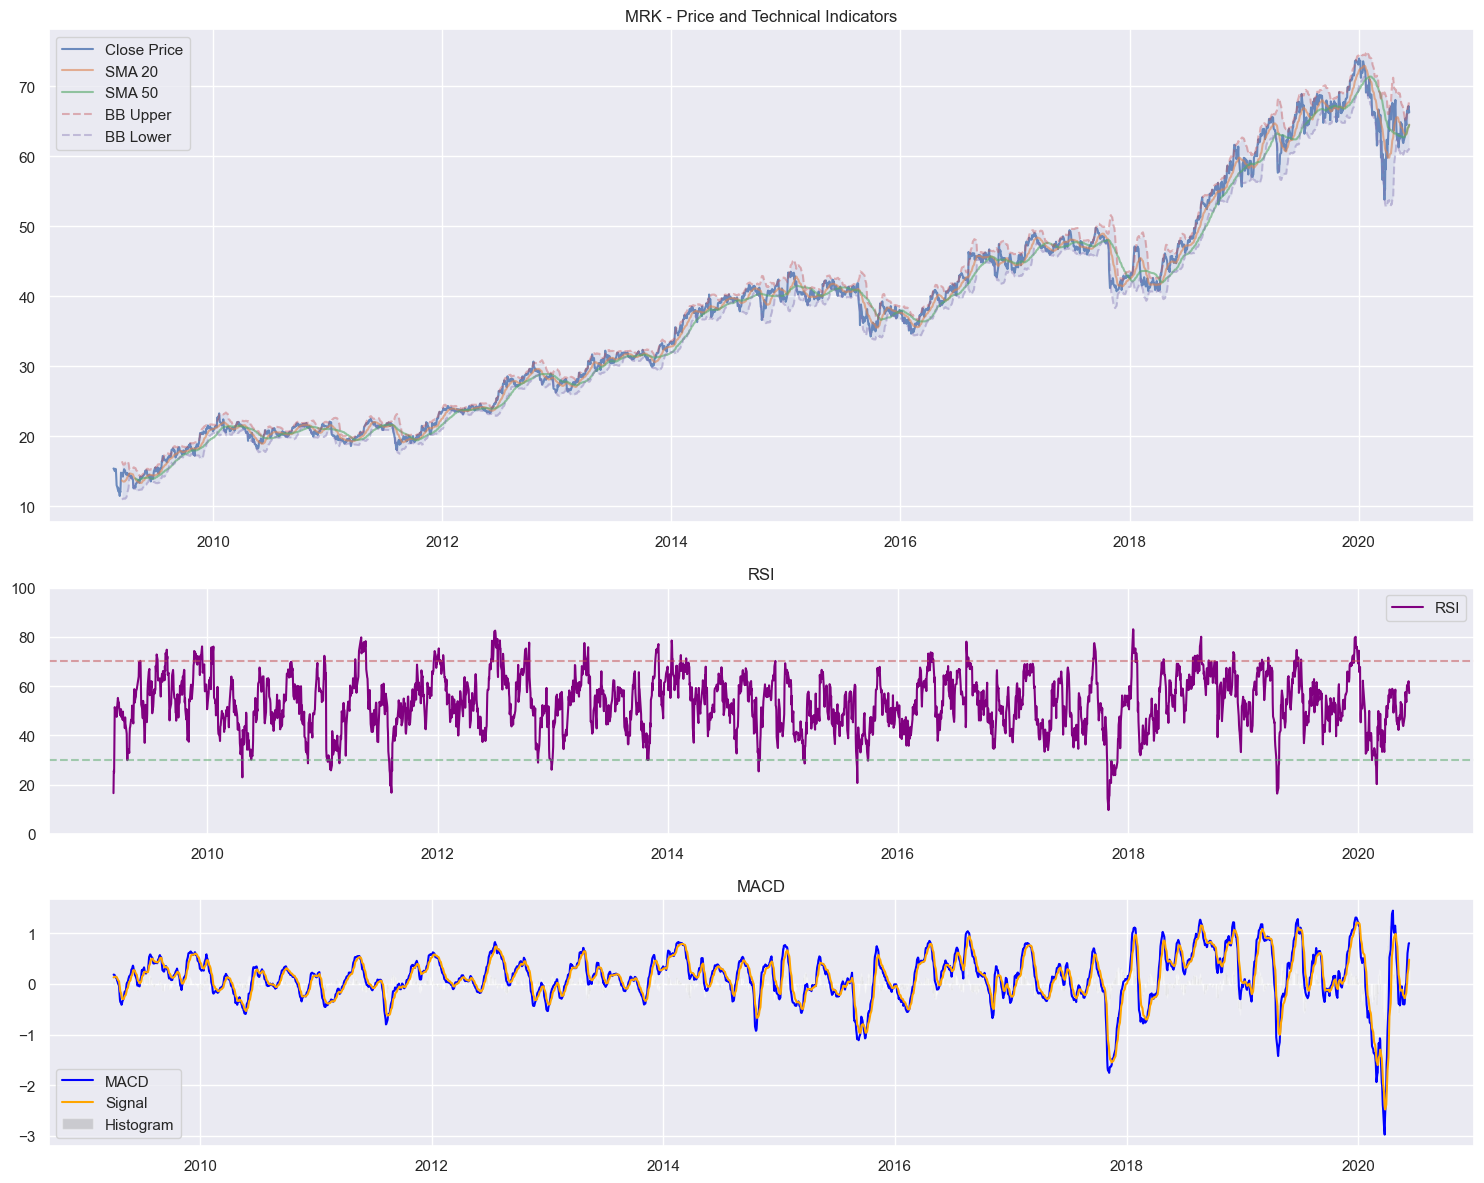

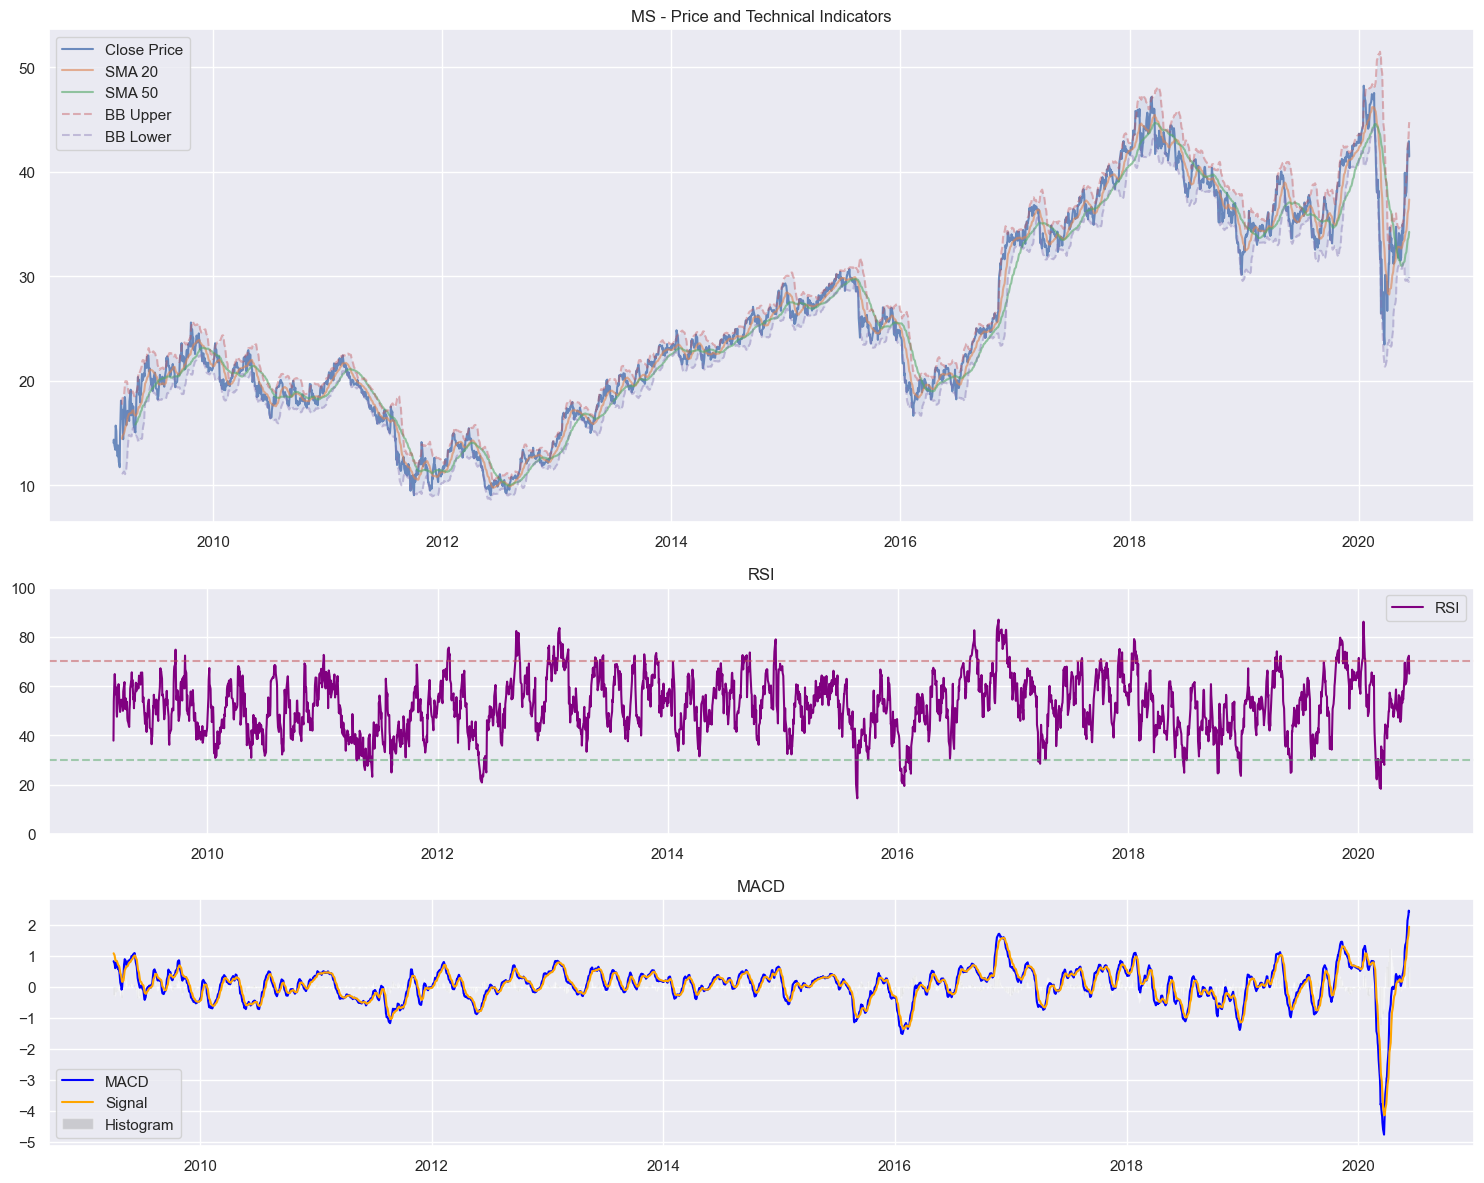

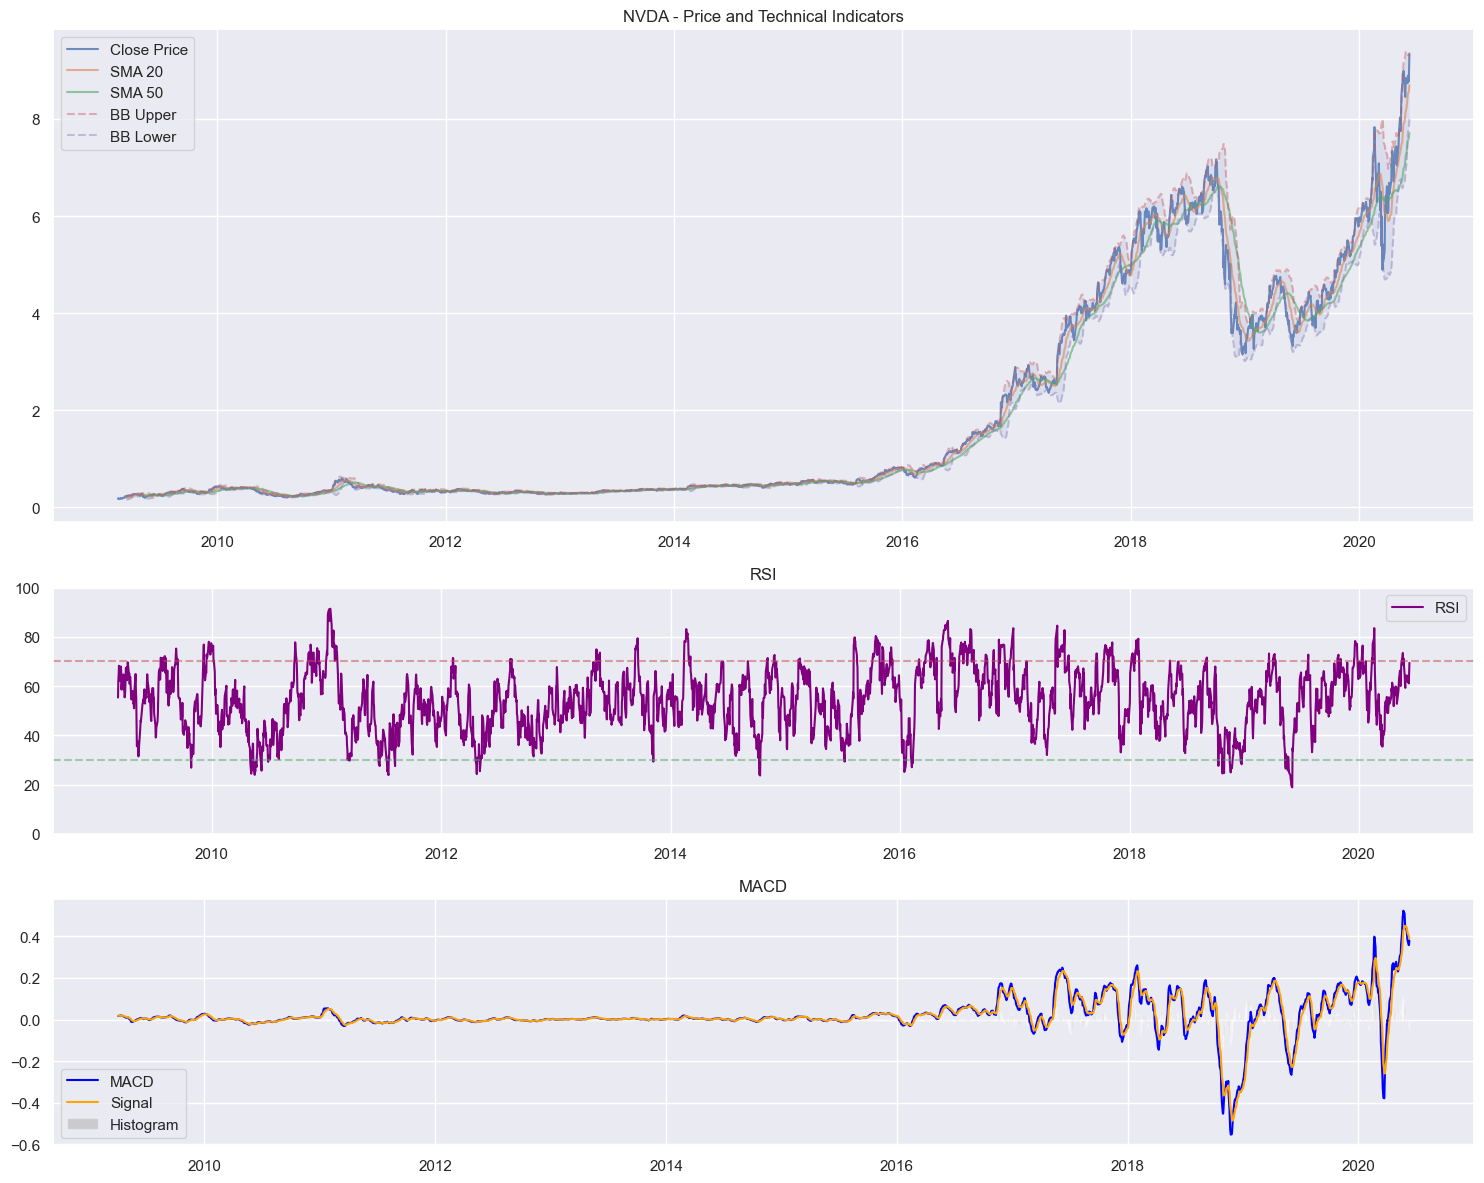

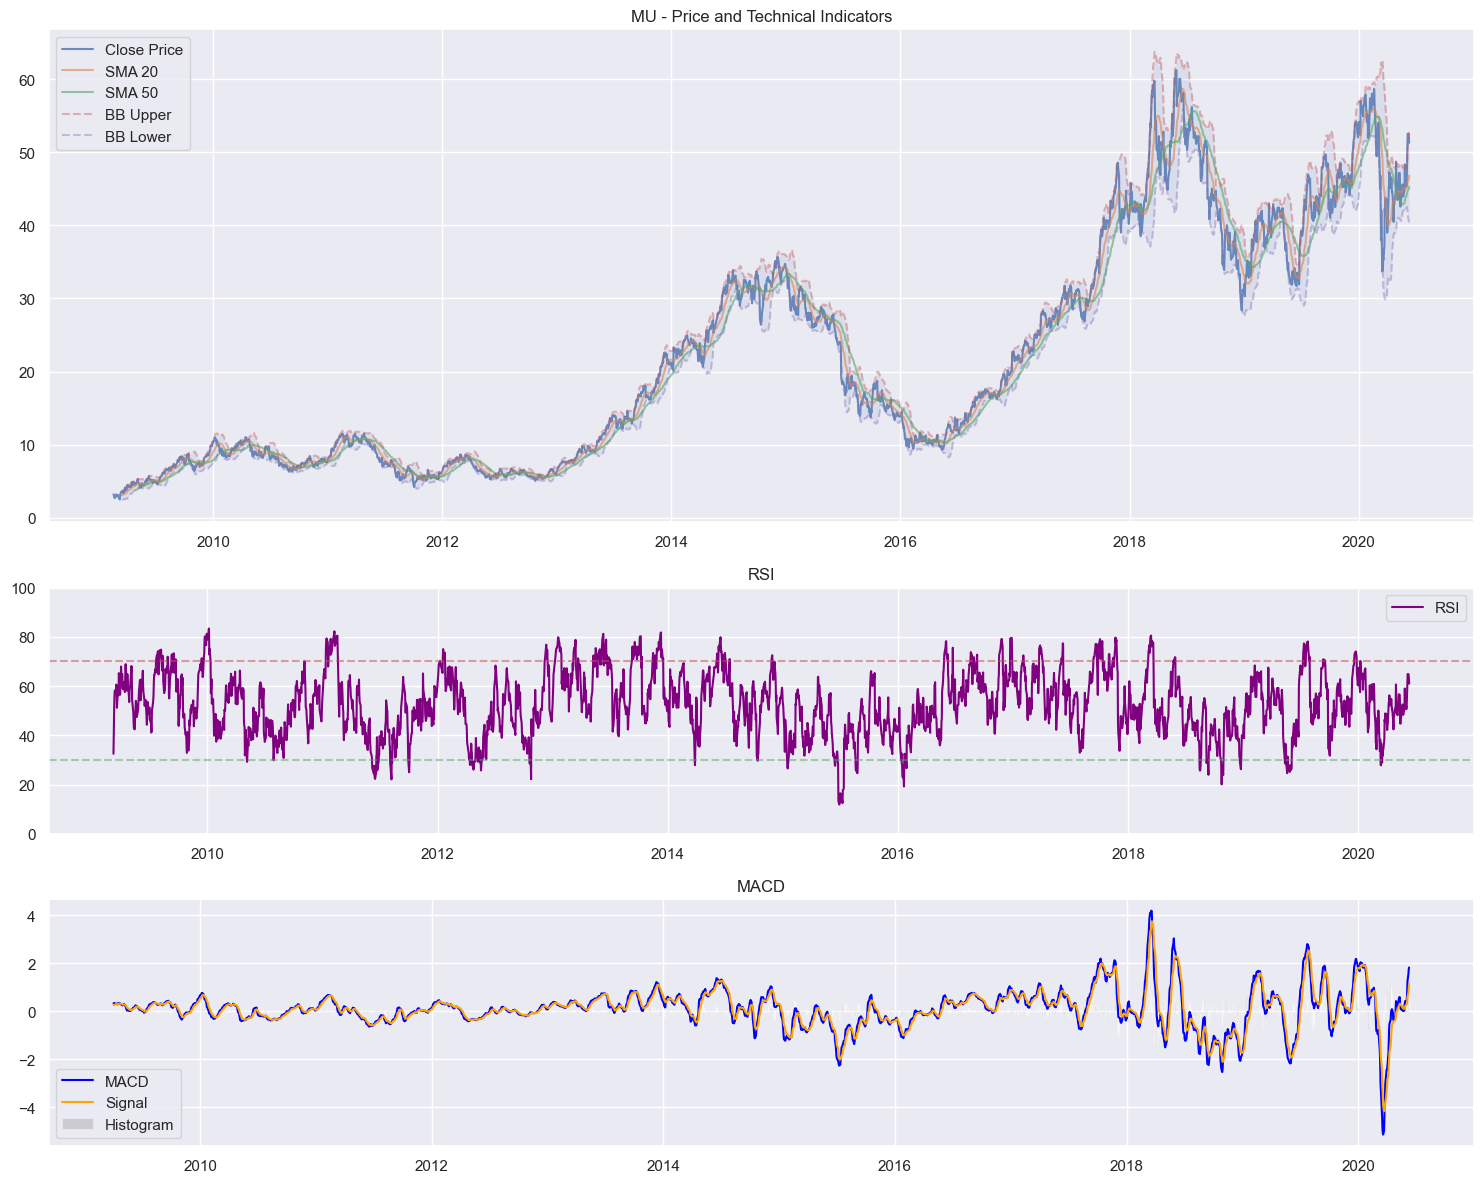

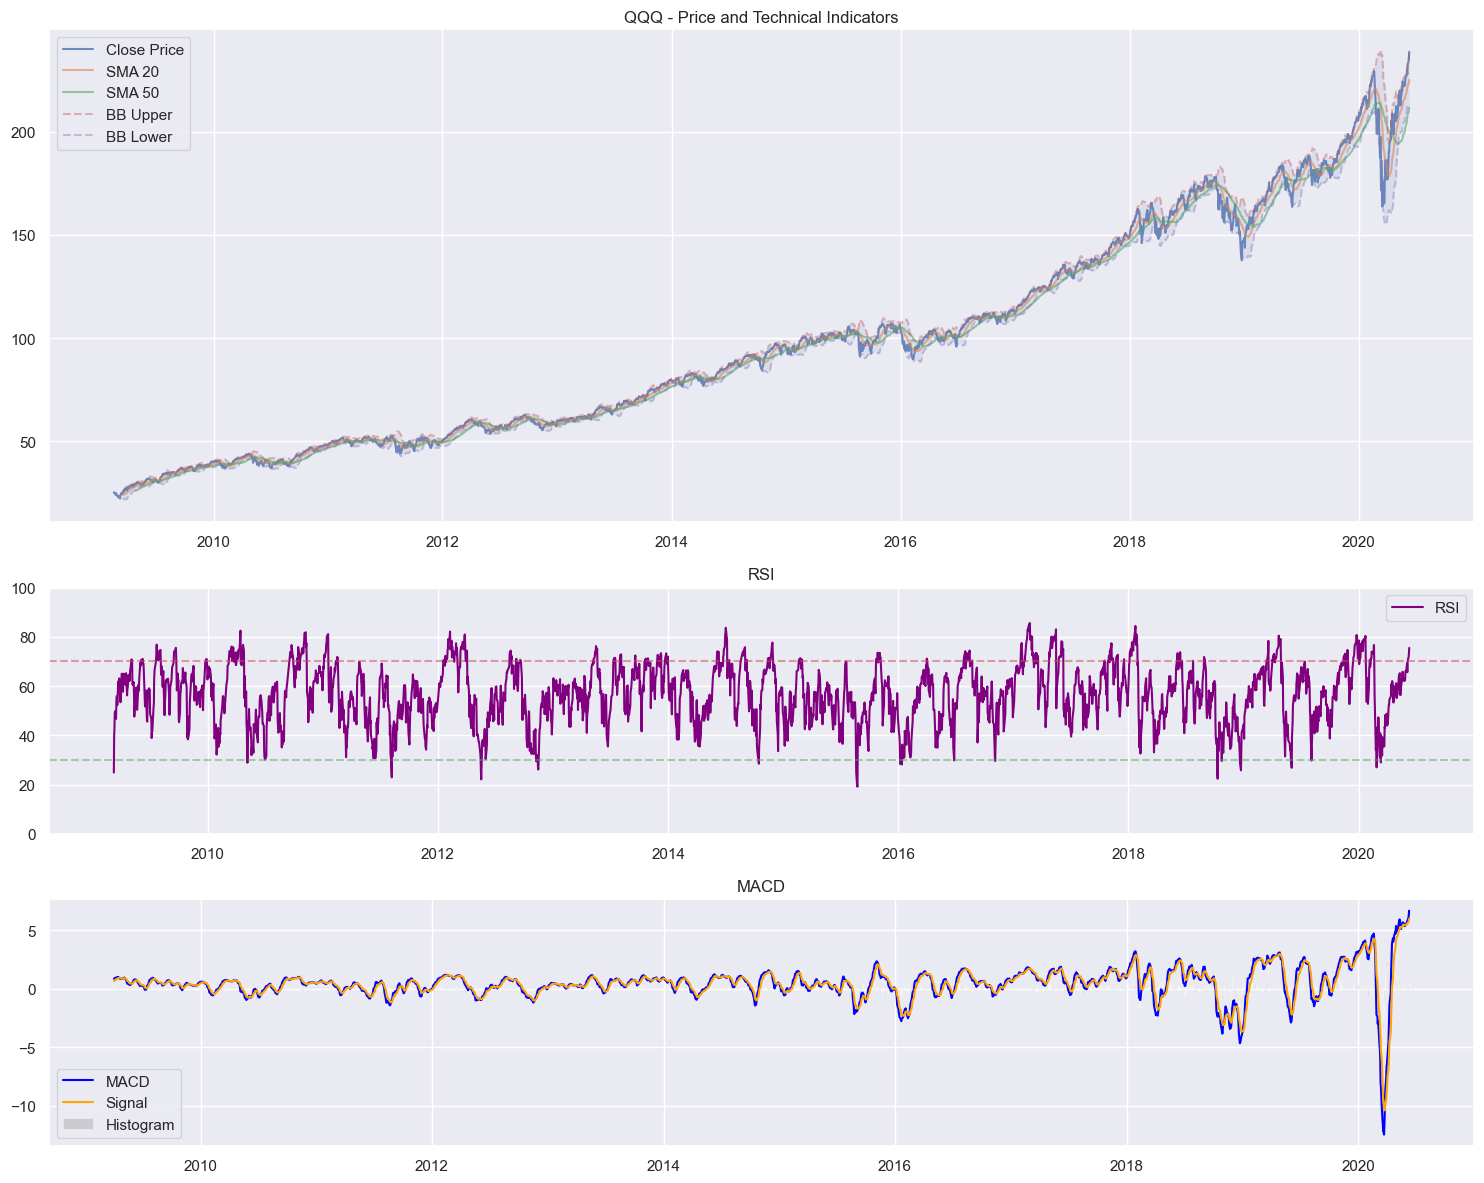

In [10]:
def plot_technical_analysis(symbol, data):
    """Create technical analysis plots for a stock."""
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1])

    # Price and Moving Averages
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(data.index, data['Close'], label='Close Price', alpha=0.8)
    ax1.plot(data.index, data['SMA_20'], label='SMA 20', alpha=0.6)
    ax1.plot(data.index, data['SMA_50'], label='SMA 50', alpha=0.6)
    ax1.plot(data.index, data['BB_Upper'], '--', label='BB Upper', alpha=0.4)
    ax1.plot(data.index, data['BB_Lower'], '--', label='BB Lower', alpha=0.4)
    ax1.fill_between(data.index, data['BB_Upper'], data['BB_Lower'], alpha=0.1)
    ax1.set_title(f'{symbol} - Price and Technical Indicators')
    ax1.legend()
    ax1.grid(True)

    # RSI
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(data.index, data['RSI'], label='RSI', color='purple')
    ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5)
    ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5)
    ax2.set_ylim(0, 100)
    ax2.set_title('RSI')
    ax2.legend()
    ax2.grid(True)

    # MACD
    ax3 = fig.add_subplot(gs[2])
    ax3.plot(data.index, data['MACD'], label='MACD', color='blue')
    ax3.plot(data.index, data['MACD_Signal'], label='Signal', color='orange')
    ax3.bar(data.index, data['MACD_Hist'], label='Histogram', alpha=0.3, color='gray')
    ax3.set_title('MACD')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

# Plot technical analysis for each stock
for symbol, analysis in analyzed_data.items():
    plot_technical_analysis(symbol, analysis['data'])


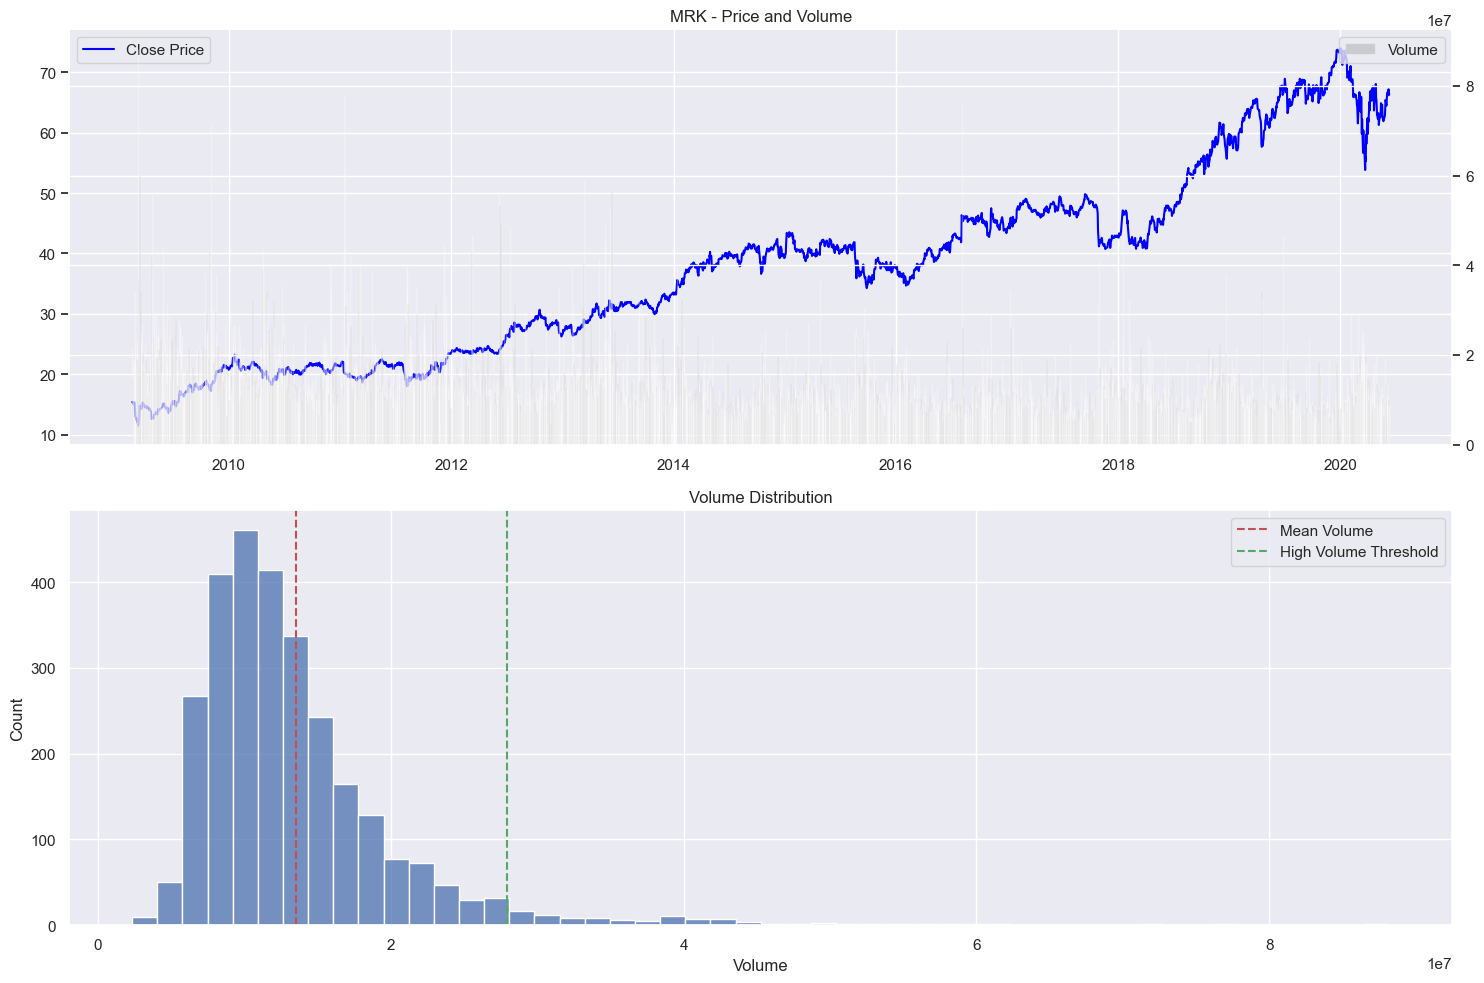

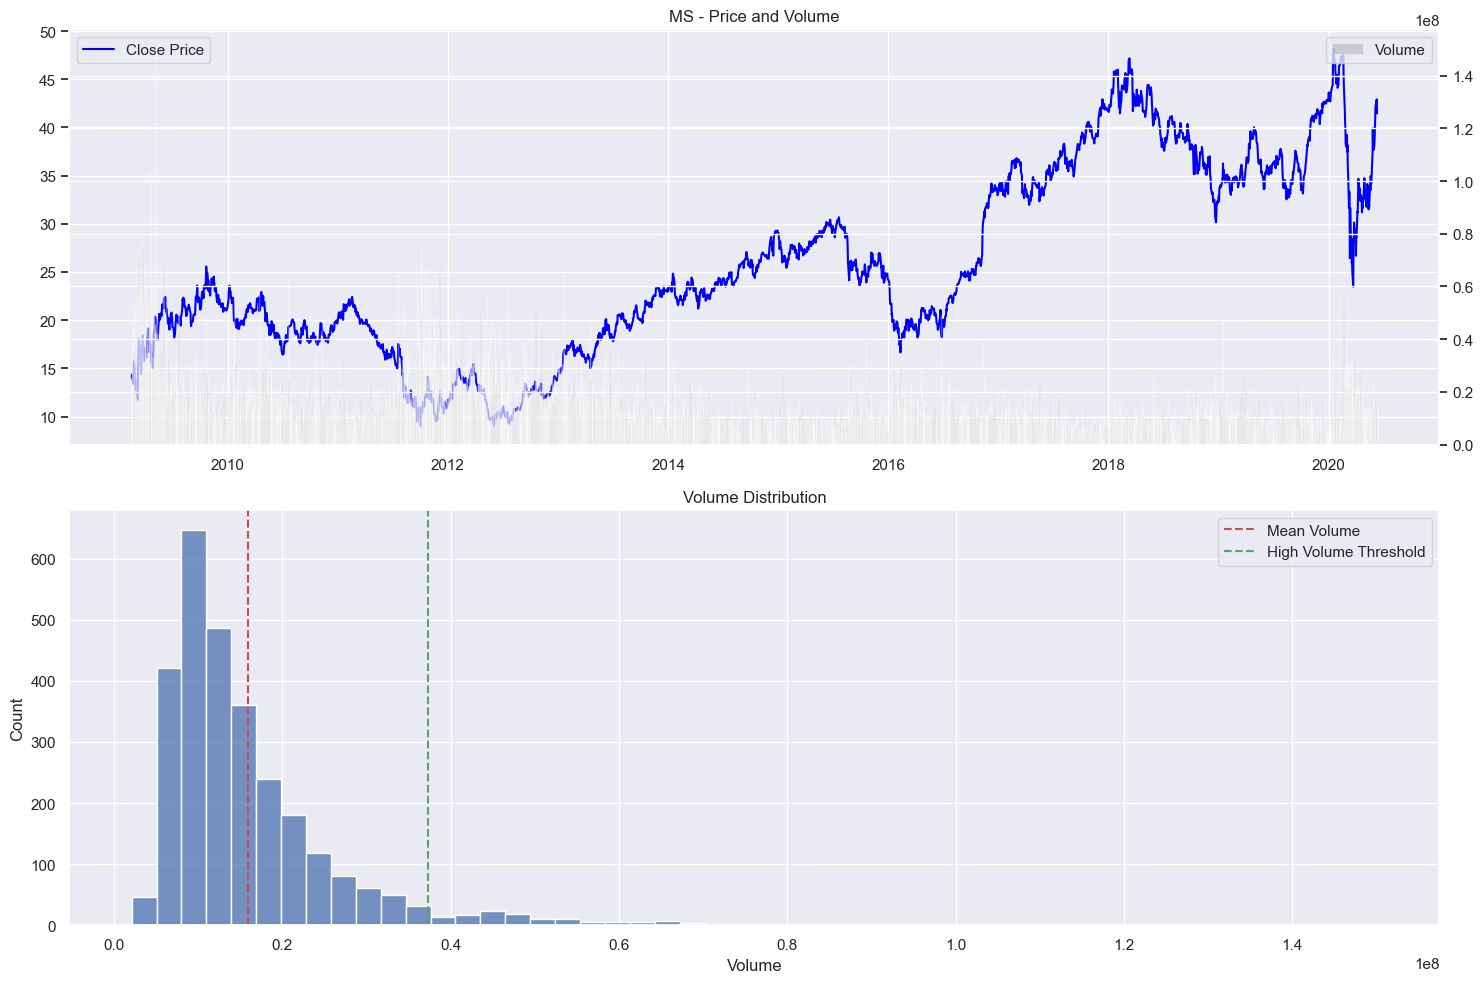

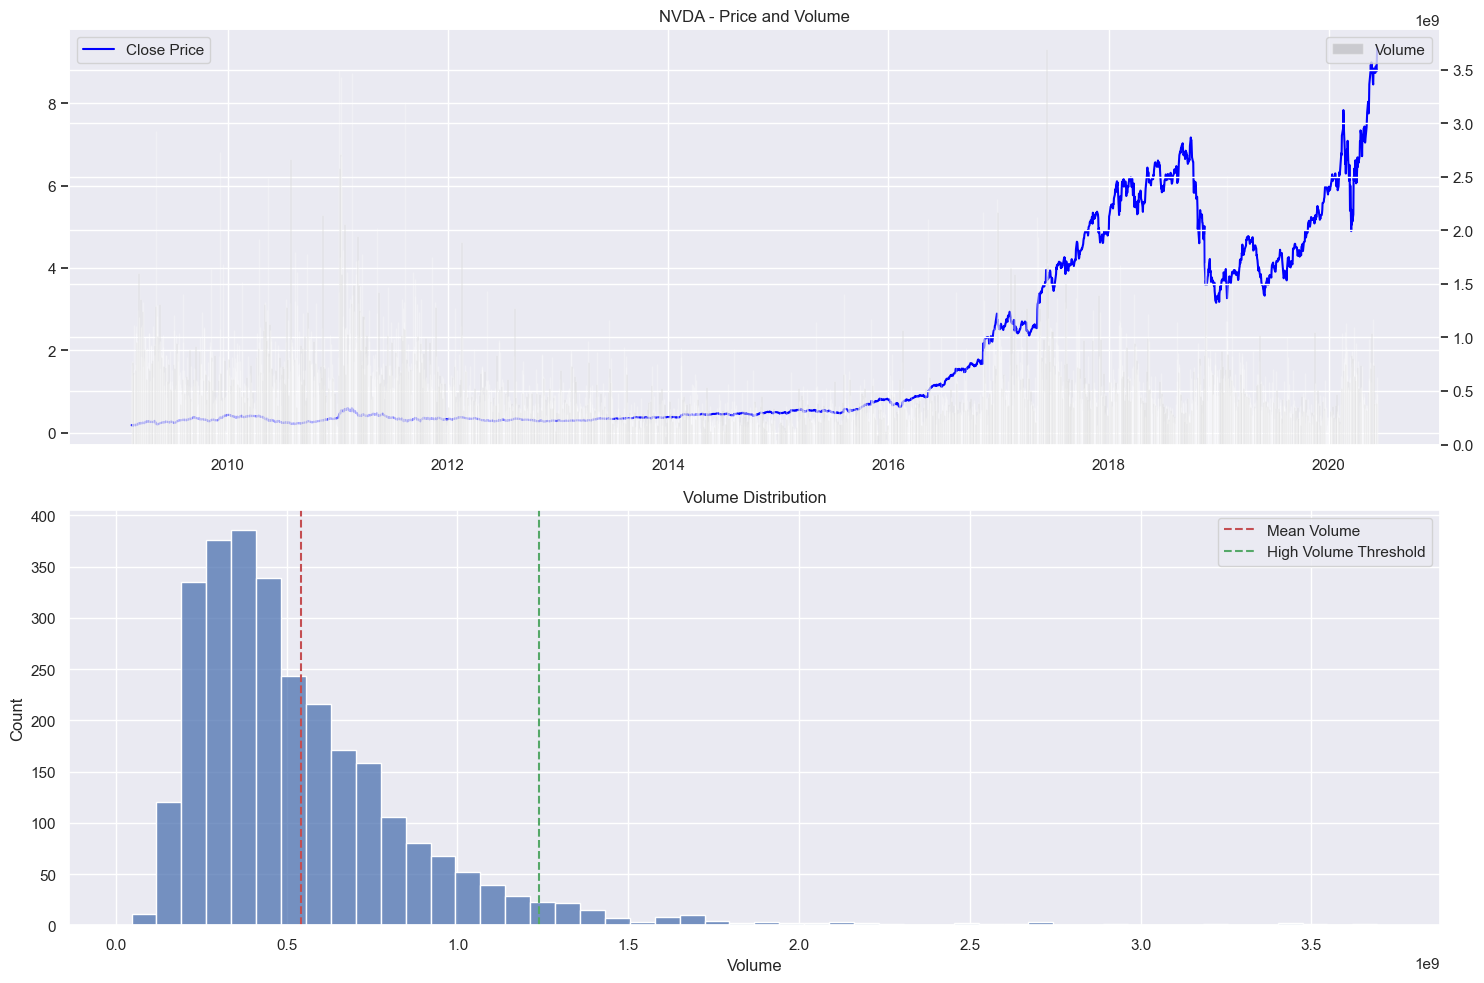

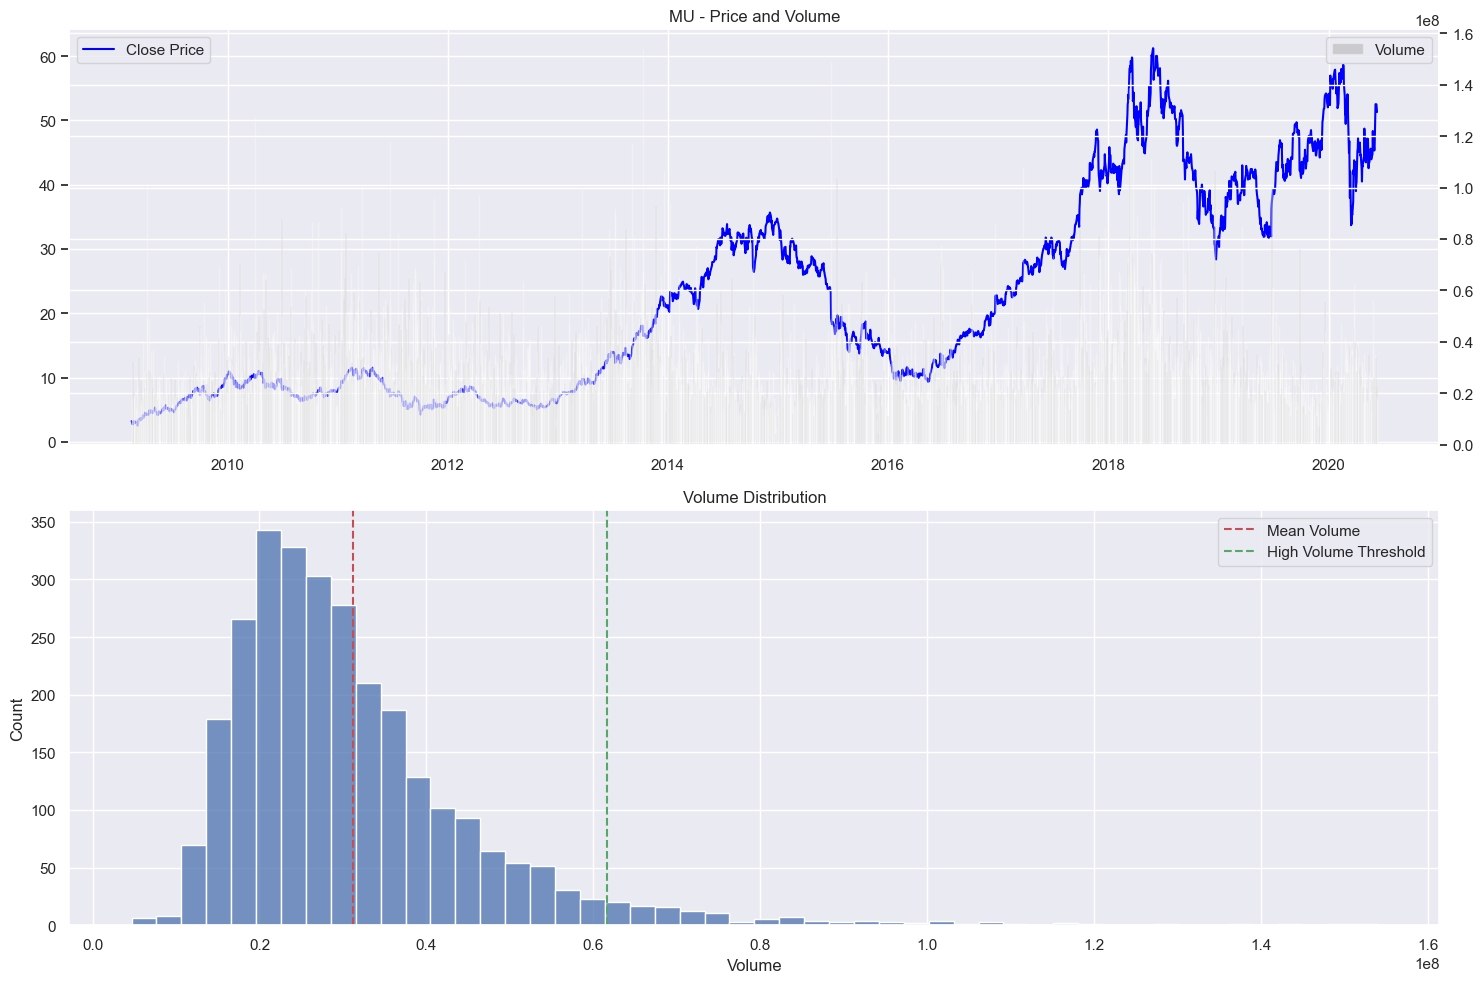

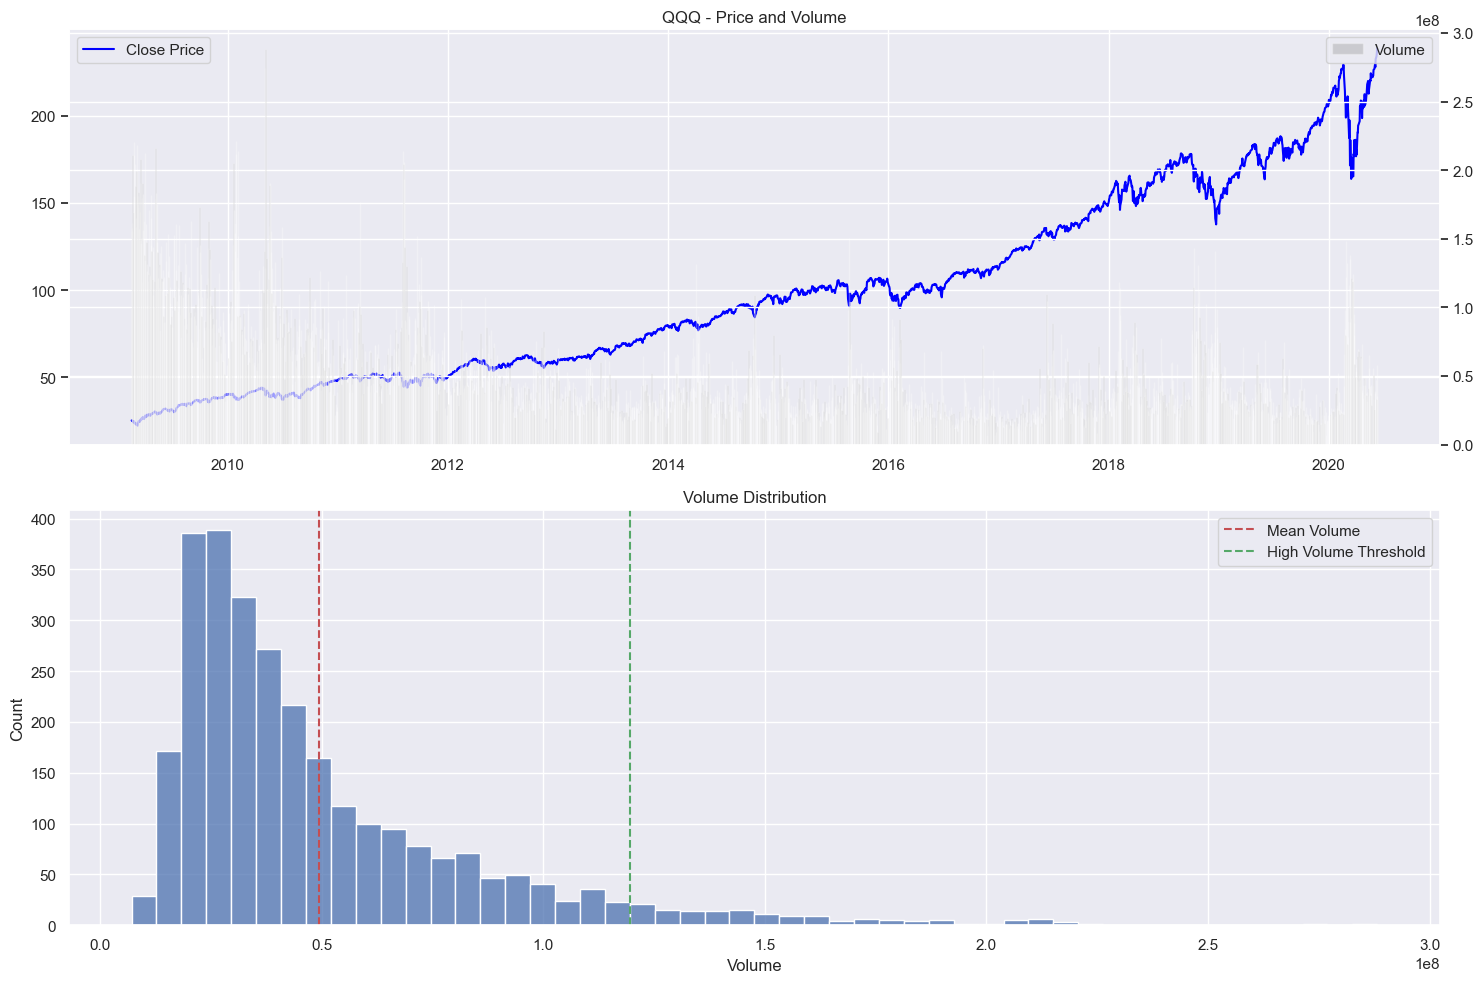

In [11]:
def plot_volume_analysis(symbol, data):
    """Create volume analysis plots for a stock."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Price and Volume
    ax1.plot(data.index, data['Close'], label='Close Price', color='blue')
    ax1_twin = ax1.twinx()
    ax1_twin.bar(data.index, data['Volume'], alpha=0.3, color='gray', label='Volume')
    ax1.set_title(f'{symbol} - Price and Volume')
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')
    ax1.grid(True)

    # Volume Distribution
    sns.histplot(data=data, x='Volume', bins=50, ax=ax2)
    ax2.axvline(data['Volume'].mean(), color='r', linestyle='--', label='Mean Volume')
    ax2.axvline(data['Volume'].mean() + 2*data['Volume'].std(), color='g', linestyle='--',
                label='High Volume Threshold')
    ax2.set_title('Volume Distribution')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Plot volume analysis for each stock
for symbol, analysis in analyzed_data.items():
    plot_volume_analysis(symbol, analysis['data'])


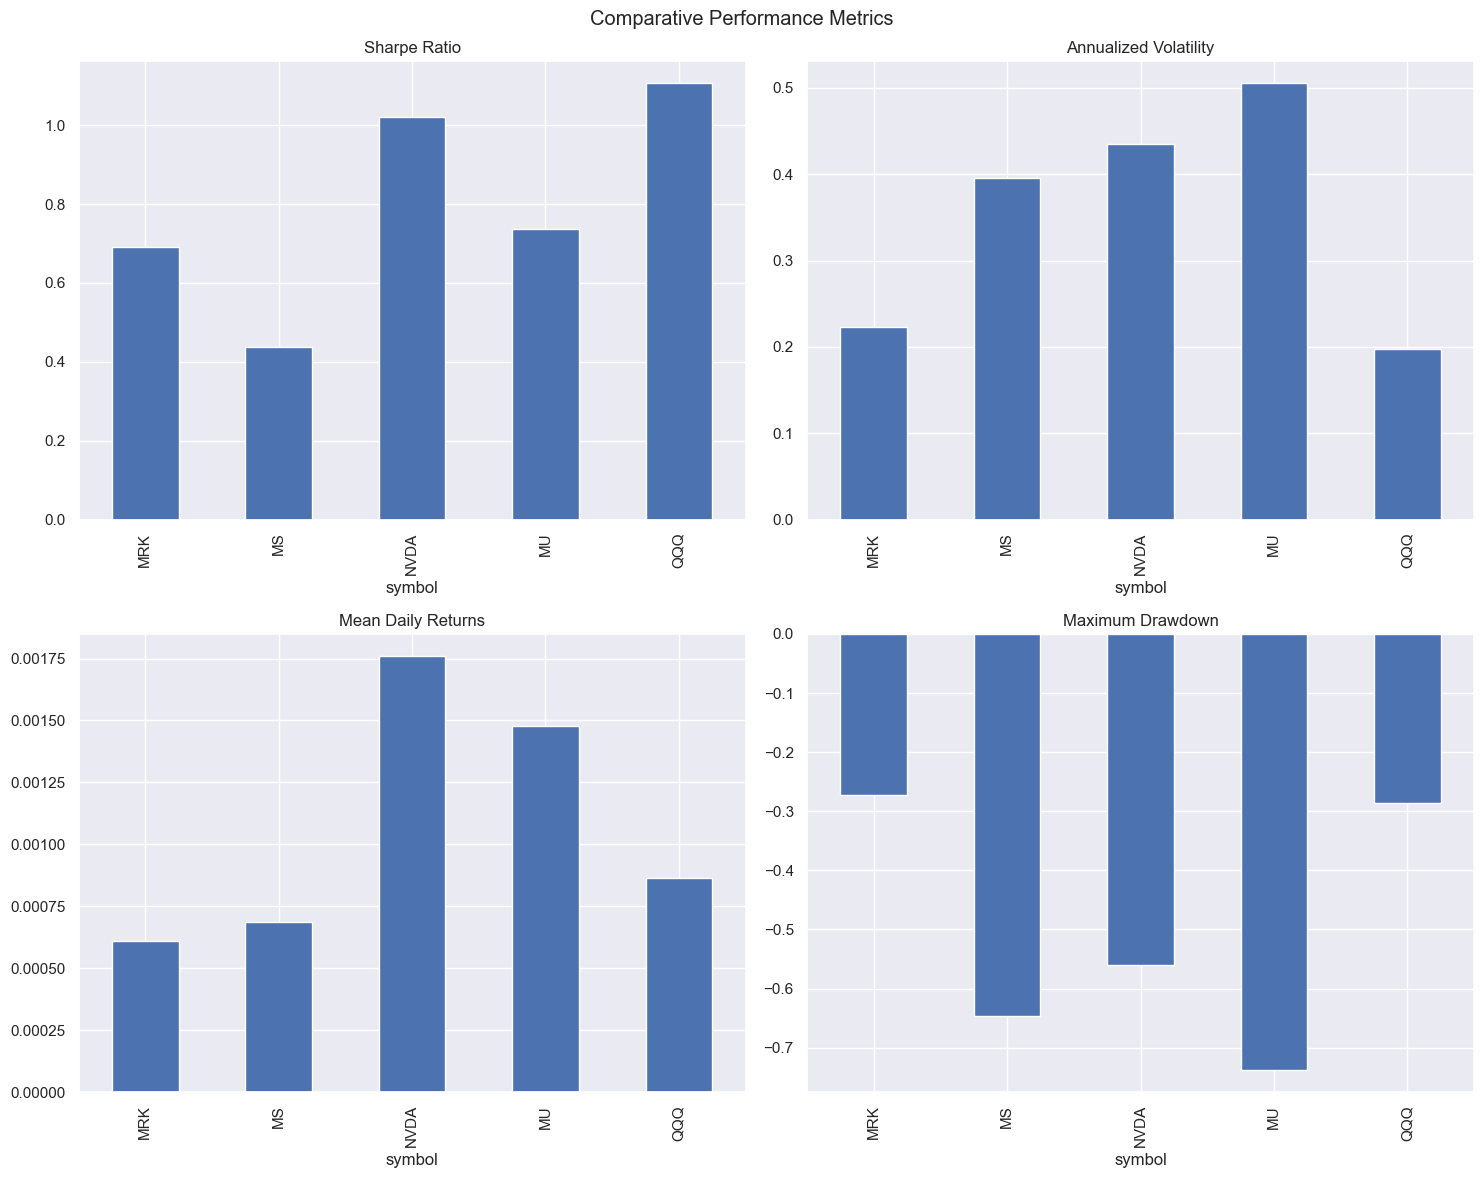


Comparative Metrics:
        daily_returns_mean  daily_returns_std  annualized_volatility  \
symbol                                                                 
MRK                 0.0006             0.0140                 0.2226   
MS                  0.0007             0.0249                 0.3960   
NVDA                0.0018             0.0274                 0.4352   
MU                  0.0015             0.0318                 0.5055   
QQQ                 0.0009             0.0124                 0.1971   

        sharpe_ratio  max_drawdown  
symbol                              
MRK           0.6911       -0.2726  
MS            0.4373       -0.6460  
NVDA          1.0199       -0.5604  
MU            0.7366       -0.7380  
QQQ           1.1063       -0.2856  


In [12]:
# Create comparative metrics dataframe
metrics_data = []
for symbol, analysis in analyzed_data.items():
    metrics = analysis['metrics']
    metrics['symbol'] = symbol
    metrics_data.append(metrics)

metrics_df = pd.DataFrame(metrics_data)
metrics_df.set_index('symbol', inplace=True)

# Plot comparative metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparative Performance Metrics')

# Sharpe Ratio
metrics_df['sharpe_ratio'].plot(kind='bar', ax=axes[0,0], title='Sharpe Ratio')
axes[0,0].grid(True)

# Volatility
metrics_df['annualized_volatility'].plot(kind='bar', ax=axes[0,1], title='Annualized Volatility')
axes[0,1].grid(True)

# Mean Returns
metrics_df['daily_returns_mean'].plot(kind='bar', ax=axes[1,0], title='Mean Daily Returns')
axes[1,0].grid(True)

# Max Drawdown
metrics_df['max_drawdown'].plot(kind='bar', ax=axes[1,1], title='Maximum Drawdown')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

# Display metrics table
print("\nComparative Metrics:")
print(metrics_df.round(4))


In [13]:
def calculate_advanced_indicators(df):
    """Calculate additional technical indicators."""
    # Stochastic Oscillator
    df['STOCH_K'], df['STOCH_D'] = talib.STOCH(df['High'],
                                               df['Low'],
                                               df['Close'],
                                               fastk_period=14,
                                               slowk_period=3,
                                               slowd_period=3)

    # Average True Range
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

    # On-Balance Volume
    df['OBV'] = talib.OBV(df['Close'], df['Volume'])

    # Momentum
    df['MOM'] = talib.MOM(df['Close'], timeperiod=14)

    # Rate of Change
    df['ROC'] = talib.ROC(df['Close'], timeperiod=14)

    # Commodity Channel Index
    df['CCI'] = talib.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)

    return df

# Calculate advanced indicators for each stock
for symbol, analysis in analyzed_data.items():
    data = analysis['data']
    analyzed_data[symbol]['data'] = calculate_advanced_indicators(data)
    print(f"Added advanced indicators for {symbol}")


Added advanced indicators for MRK
Added advanced indicators for MS
Added advanced indicators for NVDA
Added advanced indicators for MU
Added advanced indicators for QQQ


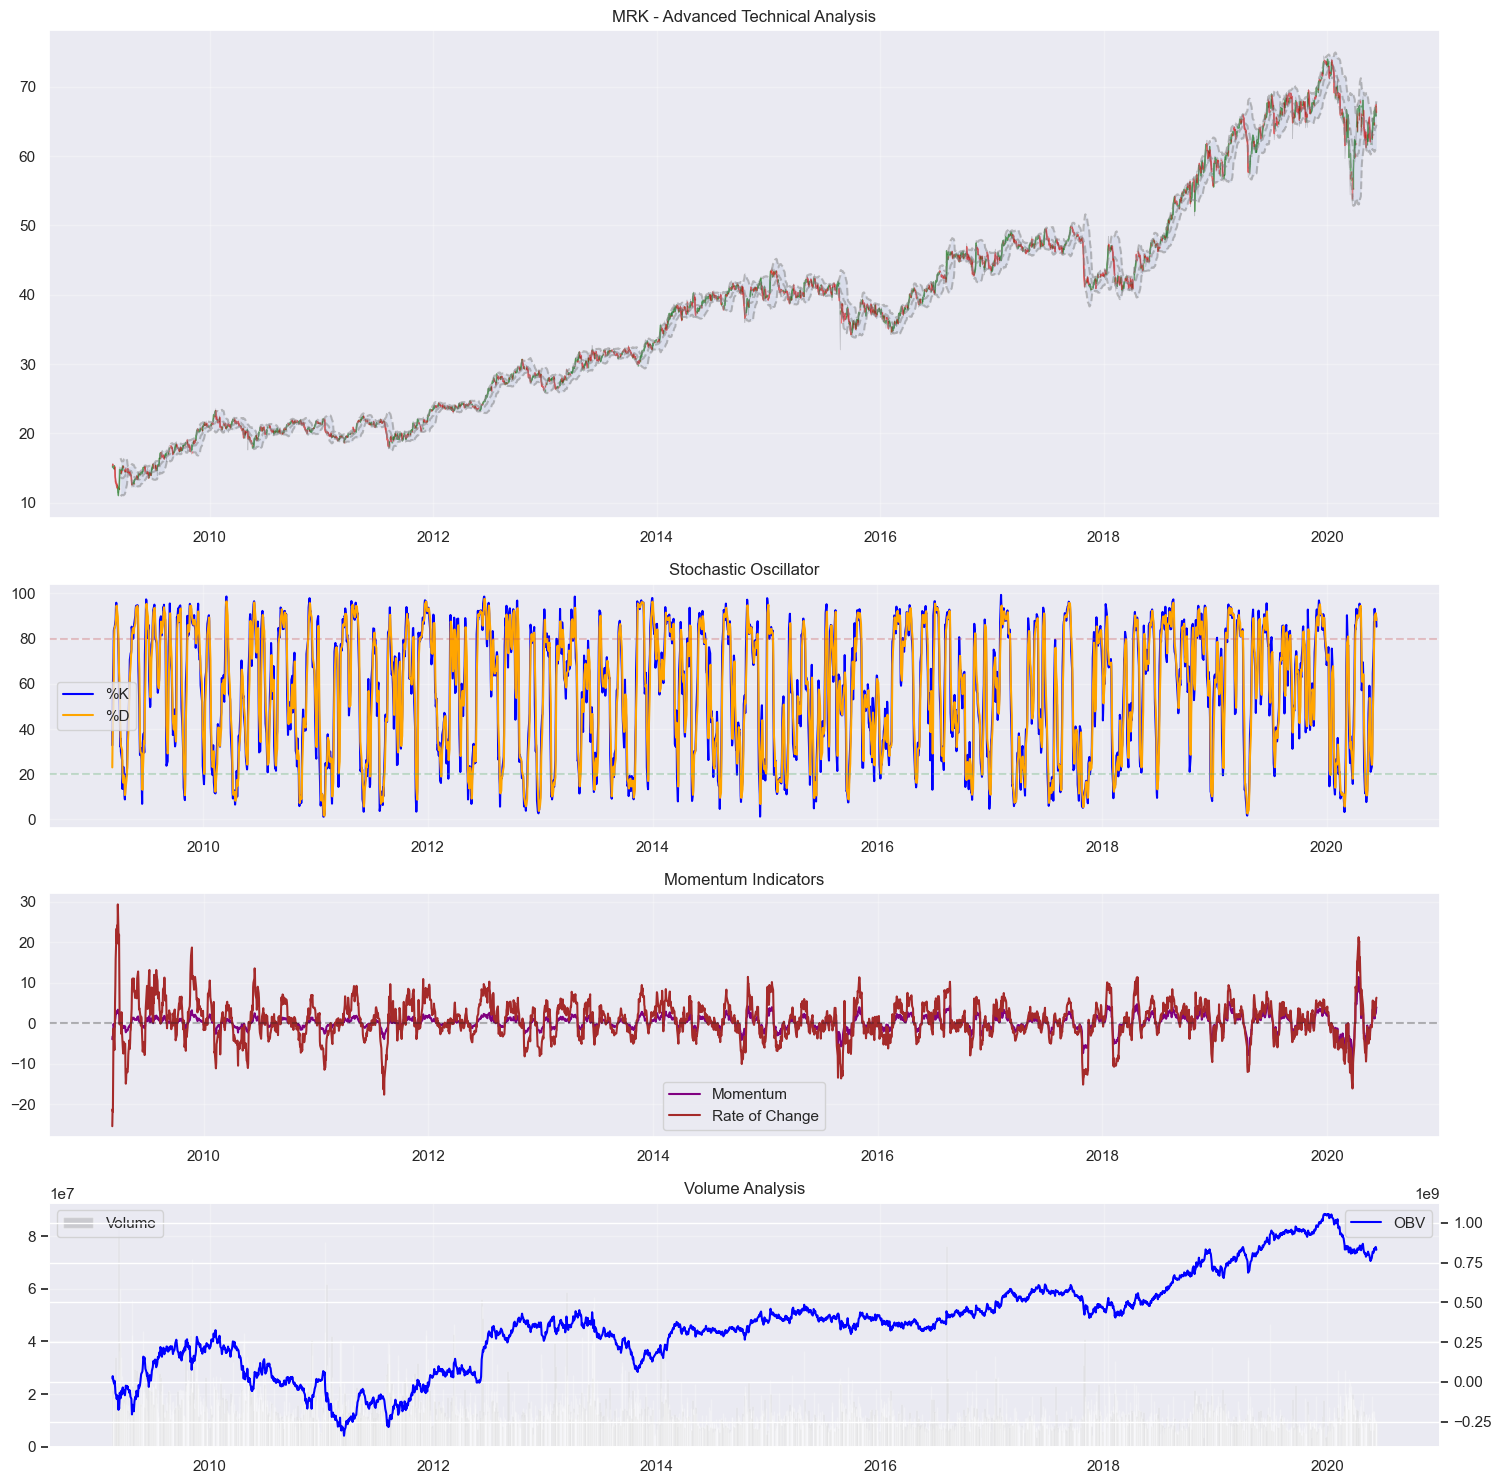


Key Statistics for MRK:
--------------------------------------------------
Current Stochastic Values: %K = 85.34, %D = 88.23
Current ATR: 1.58
Momentum: 3.95
Rate of Change: 6.35%
CCI: 67.93


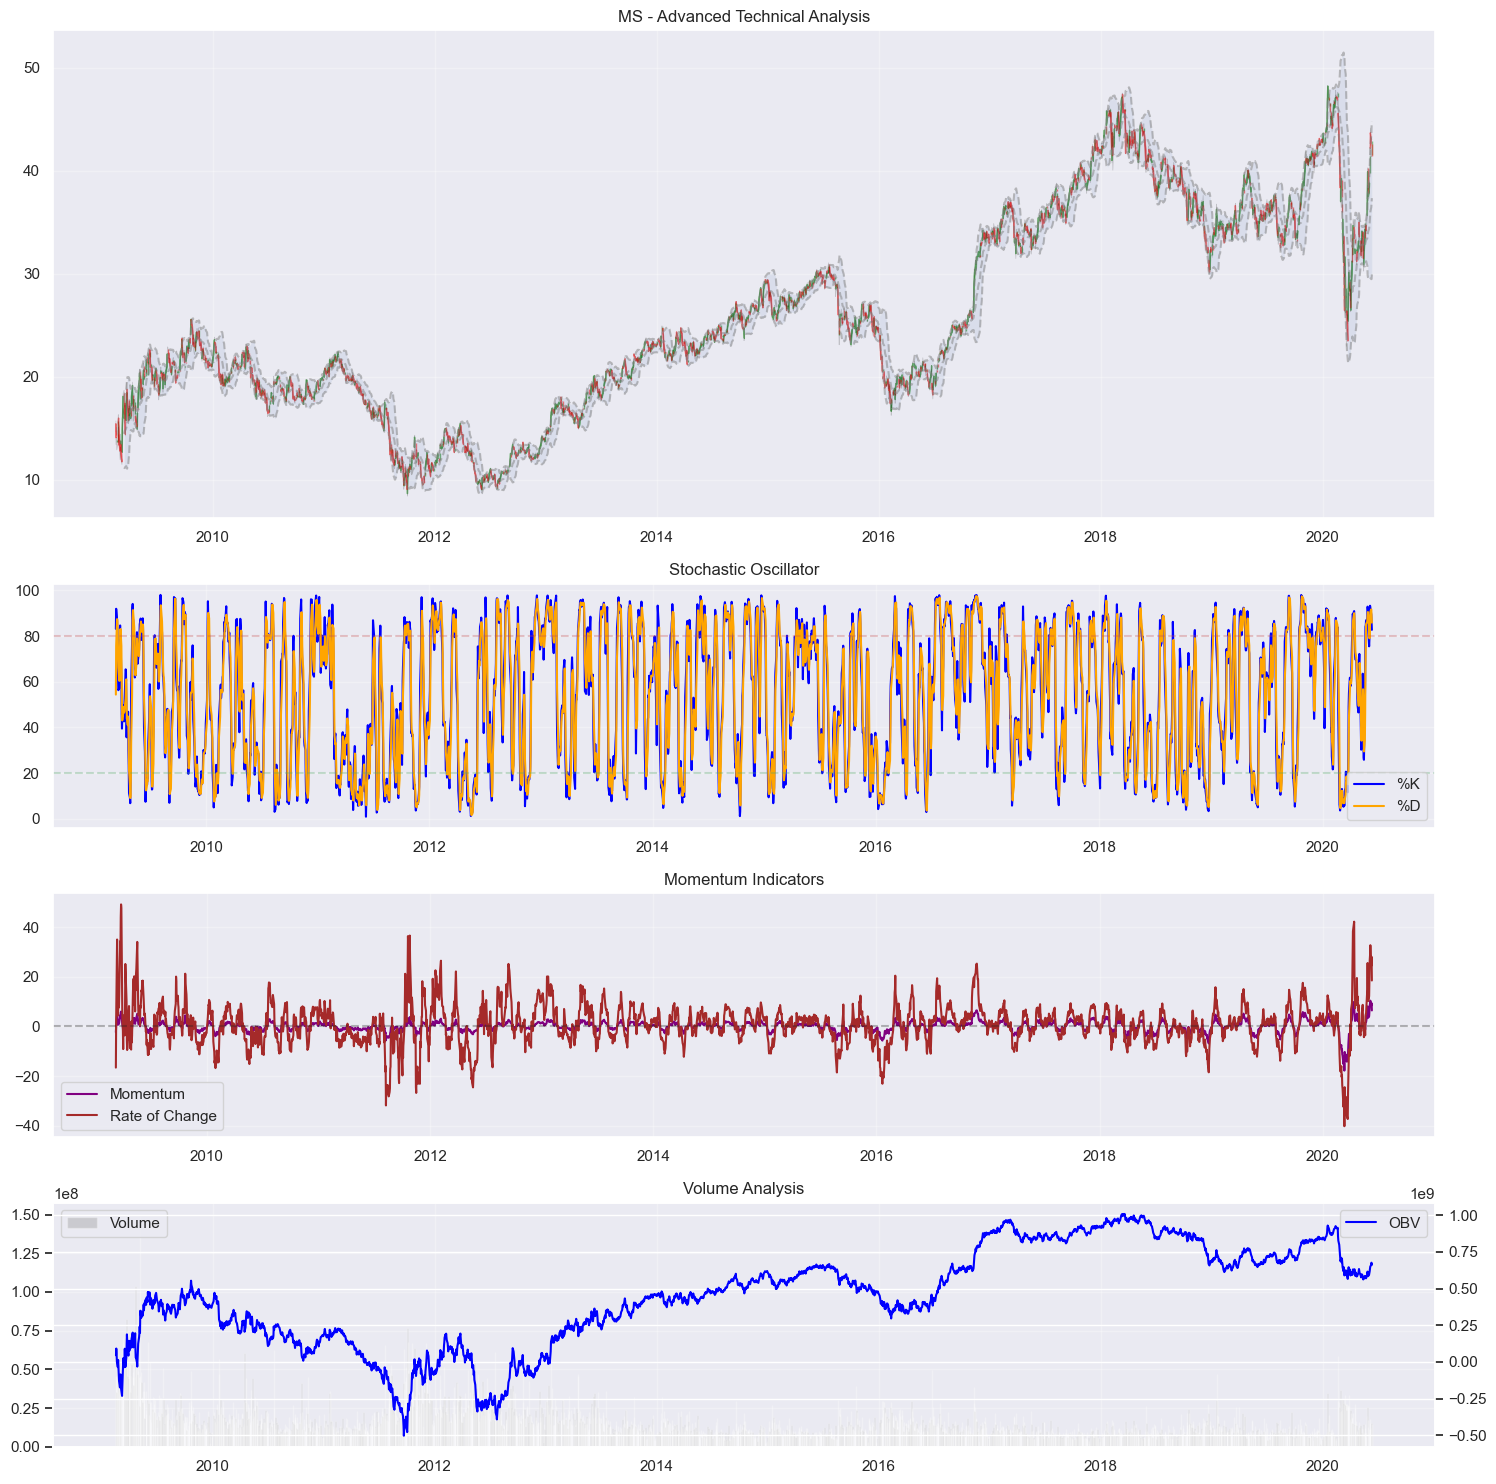


Key Statistics for MS:
--------------------------------------------------
Current Stochastic Values: %K = 82.74, %D = 85.93
Current ATR: 1.67
Momentum: 6.50
Rate of Change: 18.58%
CCI: 81.14


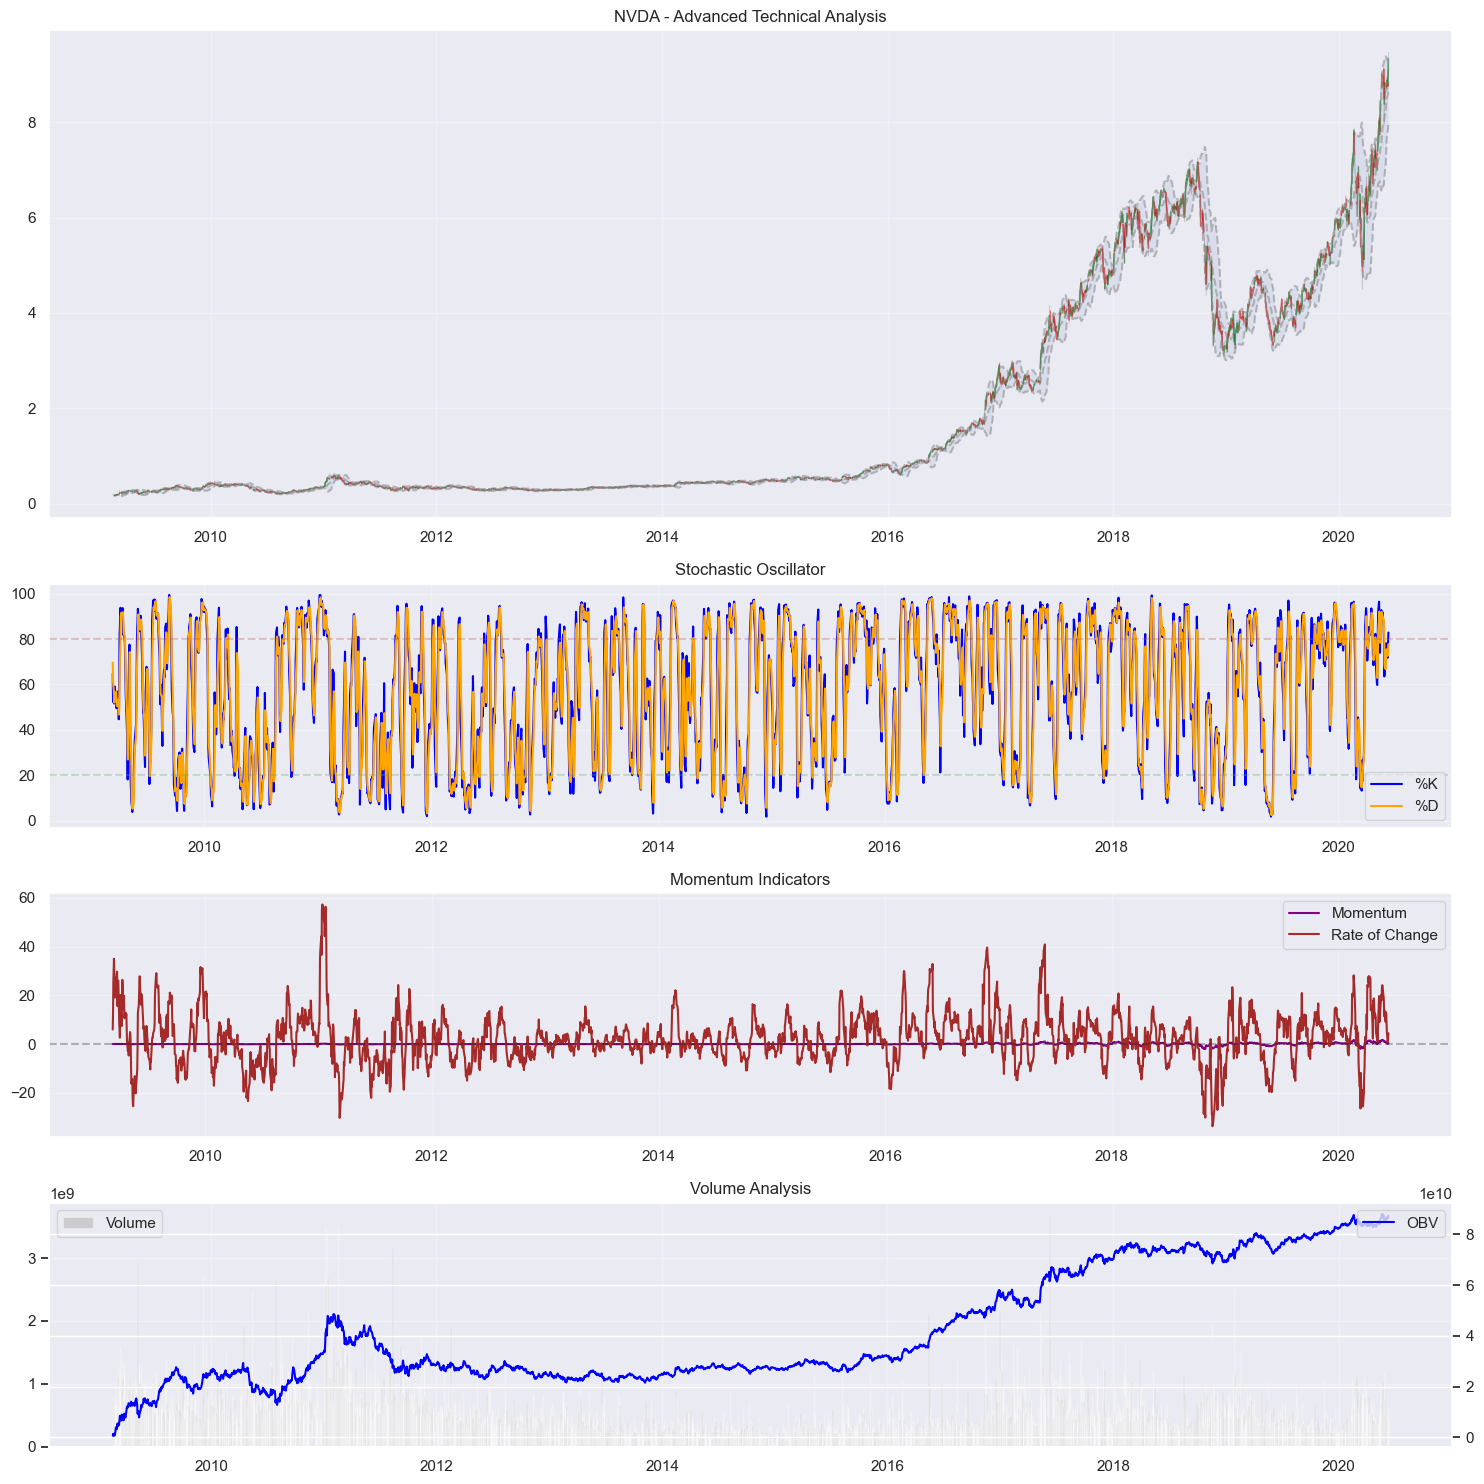


Key Statistics for NVDA:
--------------------------------------------------
Current Stochastic Values: %K = 82.87, %D = 77.74
Current ATR: 0.34
Momentum: 0.40
Rate of Change: 4.47%
CCI: 260.08


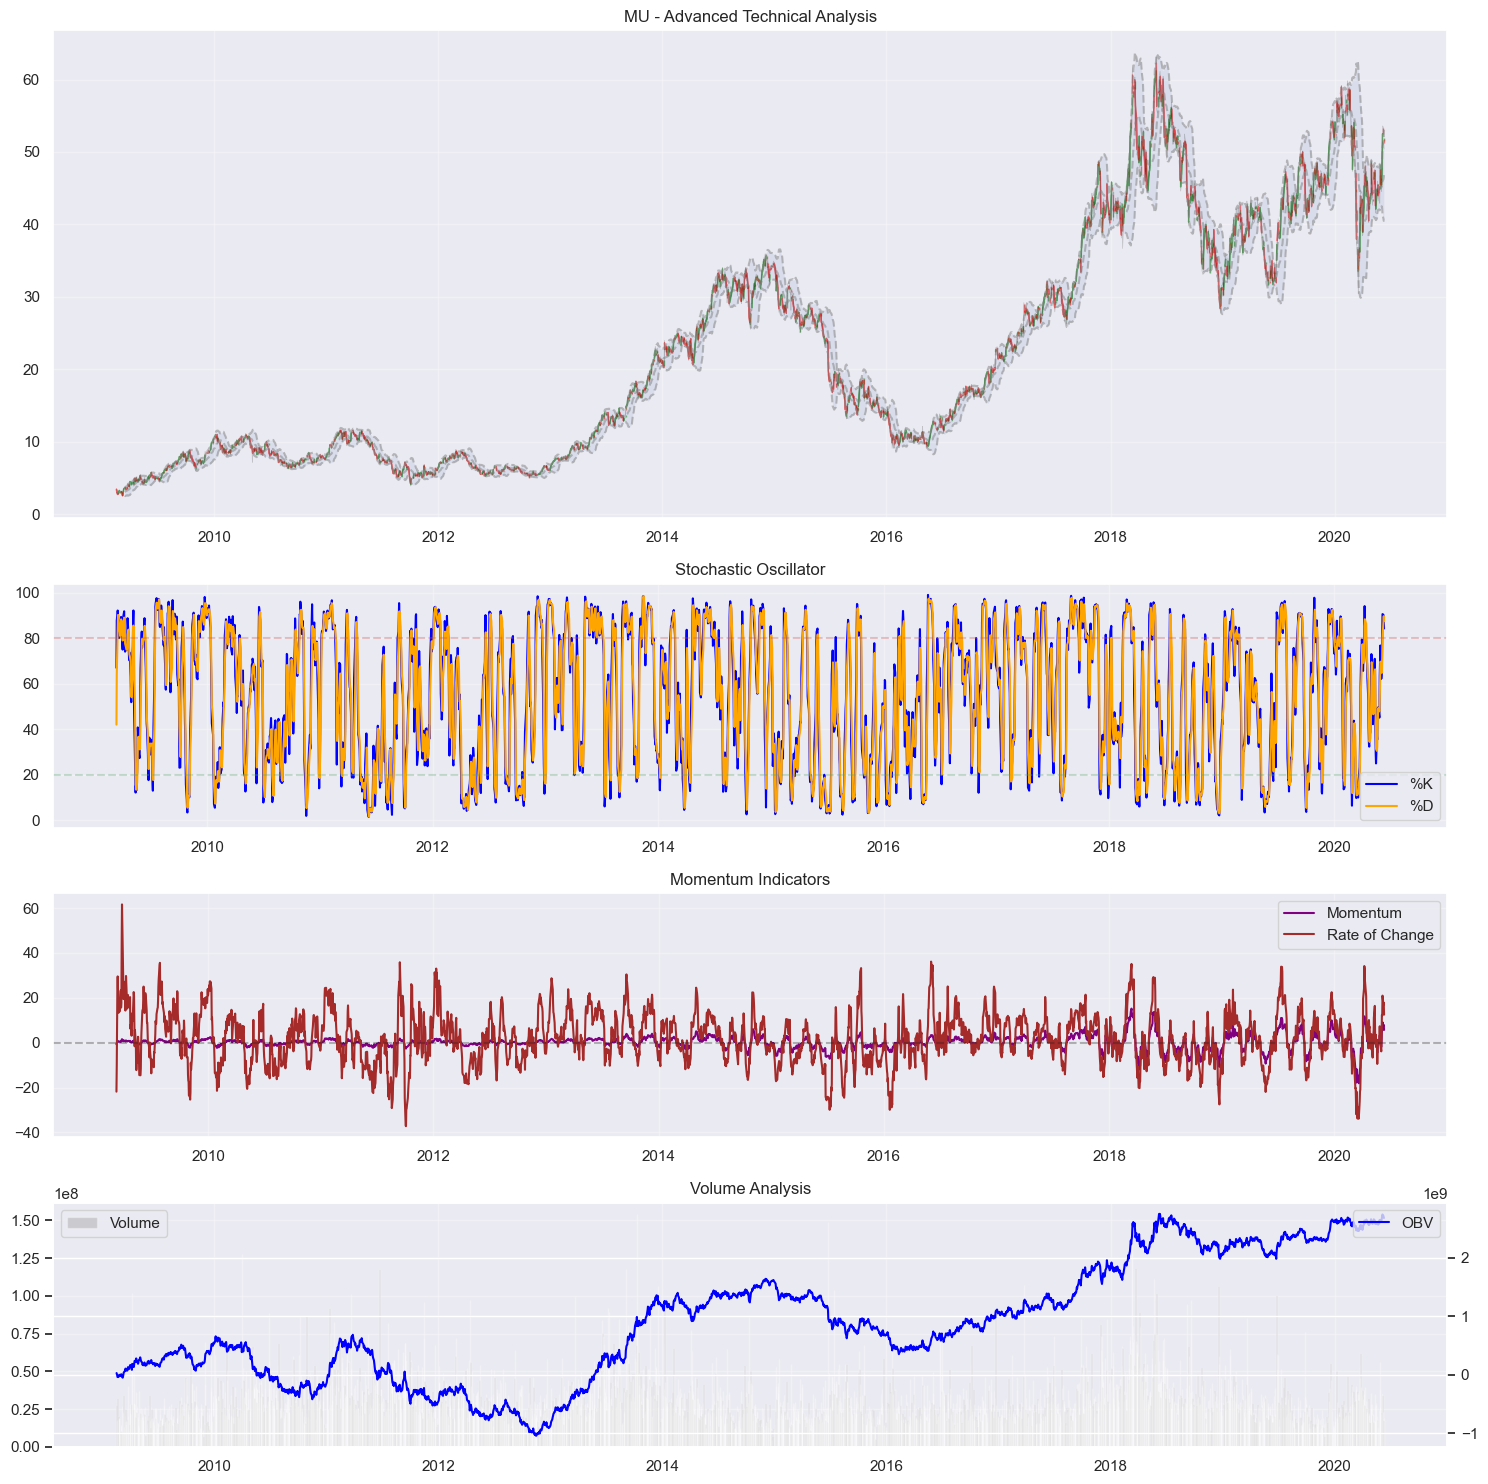


Key Statistics for MU:
--------------------------------------------------
Current Stochastic Values: %K = 84.31, %D = 87.59
Current ATR: 2.30
Momentum: 5.70
Rate of Change: 12.50%
CCI: 88.08


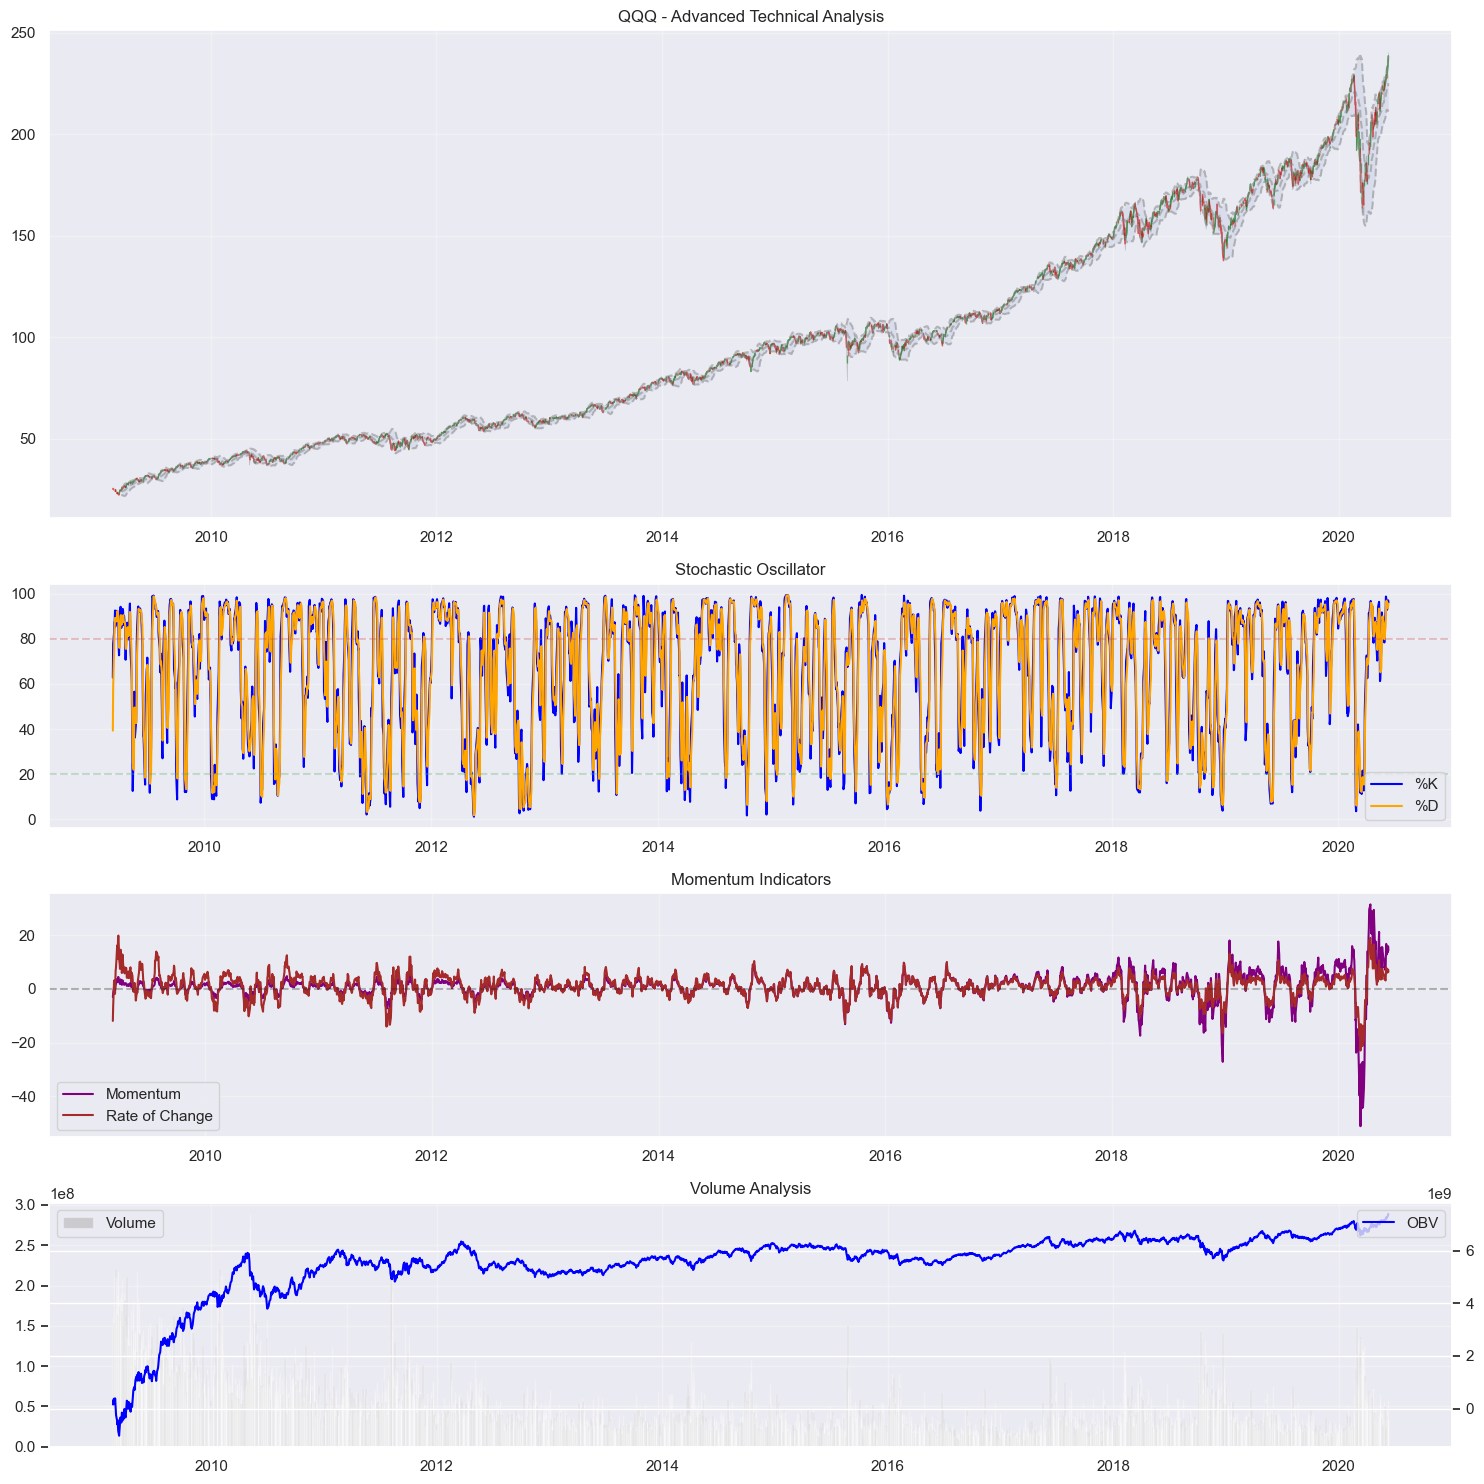


Key Statistics for QQQ:
--------------------------------------------------
Current Stochastic Values: %K = 96.07, %D = 95.64
Current ATR: 4.43
Momentum: 14.38
Rate of Change: 6.41%
CCI: 172.55


In [14]:
def plot_advanced_analysis(symbol, data):
    """Create advanced technical analysis plots."""
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 15))
    gs = fig.add_gridspec(4, 1, height_ratios=[2, 1, 1, 1])

    # Price and Volume with Candlestick-style
    ax1 = fig.add_subplot(gs[0])
    # Plot candlestick-like representation
    ax1.fill_between(data.index, data['Open'], data['Close'],
                    where=(data['Close'] >= data['Open']),
                    color='green', alpha=0.5)
    ax1.fill_between(data.index, data['Open'], data['Close'],
                    where=(data['Close'] < data['Open']),
                    color='red', alpha=0.5)
    ax1.plot(data.index, data['High'], 'k-', alpha=0.2, linewidth=0.5)
    ax1.plot(data.index, data['Low'], 'k-', alpha=0.2, linewidth=0.5)

    # Add Bollinger Bands
    ax1.plot(data.index, data['BB_Upper'], '--', color='gray', alpha=0.5)
    ax1.plot(data.index, data['BB_Middle'], '--', color='gray', alpha=0.5)
    ax1.plot(data.index, data['BB_Lower'], '--', color='gray', alpha=0.5)
    ax1.fill_between(data.index, data['BB_Upper'], data['BB_Lower'], alpha=0.1)

    ax1.set_title(f'{symbol} - Advanced Technical Analysis')
    ax1.grid(True, alpha=0.3)

    # Stochastic Oscillator
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(data.index, data['STOCH_K'], label='%K', color='blue')
    ax2.plot(data.index, data['STOCH_D'], label='%D', color='orange')
    ax2.axhline(y=80, color='r', linestyle='--', alpha=0.3)
    ax2.axhline(y=20, color='g', linestyle='--', alpha=0.3)
    ax2.set_title('Stochastic Oscillator')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # Momentum Indicators
    ax3 = fig.add_subplot(gs[2])
    ax3.plot(data.index, data['MOM'], label='Momentum', color='purple')
    ax3.plot(data.index, data['ROC'], label='Rate of Change', color='brown')
    ax3.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax3.set_title('Momentum Indicators')
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # Volume and OBV
    ax4 = fig.add_subplot(gs[3])
    ax4.bar(data.index, data['Volume'], alpha=0.3, color='gray', label='Volume')
    ax4_twin = ax4.twinx()
    ax4_twin.plot(data.index, data['OBV'], color='blue', label='OBV')
    ax4.set_title('Volume Analysis')
    ax4.grid(True, alpha=0.3)
    ax4.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Print key statistics
    print(f"\nKey Statistics for {symbol}:")
    print("-" * 50)
    print(f"Current Stochastic Values: %K = {data['STOCH_K'].iloc[-1]:.2f}, %D = {data['STOCH_D'].iloc[-1]:.2f}")
    print(f"Current ATR: {data['ATR'].iloc[-1]:.2f}")
    print(f"Momentum: {data['MOM'].iloc[-1]:.2f}")
    print(f"Rate of Change: {data['ROC'].iloc[-1]:.2f}%")
    print(f"CCI: {data['CCI'].iloc[-1]:.2f}")

# Plot advanced analysis for each stock
for symbol, analysis in analyzed_data.items():
    plot_advanced_analysis(symbol, analysis['data'])


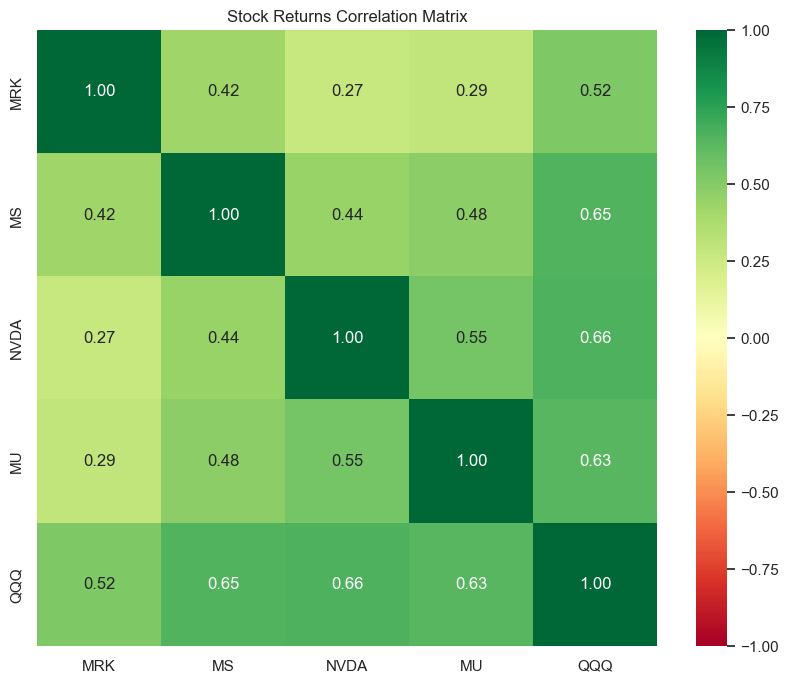


Correlation Analysis Insights:
--------------------------------------------------
MRK vs MS: 0.419
MRK vs NVDA: 0.270
MRK vs MU: 0.292
MRK vs QQQ: 0.522
MS vs NVDA: 0.444
MS vs MU: 0.483
MS vs QQQ: 0.651
NVDA vs MU: 0.551
NVDA vs QQQ: 0.659
MU vs QQQ: 0.633


In [15]:
# Create a DataFrame with all stock returns
returns_df = pd.DataFrame()
for symbol, analysis in analyzed_data.items():
    returns_df[symbol] = analysis['data']['Close'].pct_change()

# Calculate correlation matrix
correlation_matrix = returns_df.corr()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='RdYlGn',
            center=0,
            vmin=-1,
            vmax=1,
            fmt='.2f')
plt.title('Stock Returns Correlation Matrix')
plt.show()

# Print correlation insights
print("\nCorrelation Analysis Insights:")
print("-" * 50)
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        stock1 = correlation_matrix.columns[i]
        stock2 = correlation_matrix.columns[j]
        corr = correlation_matrix.iloc[i,j]
        print(f"{stock1} vs {stock2}: {corr:.3f}")
        if abs(corr) > 0.8:
            print("  → Strong correlation")
        elif abs(corr) < 0.2:
            print("  → Weak correlation (good for diversification)")
